# NN Training Performance Investigation

I have trained a bunch of NNs, one of them (the one I will study here) using xxx.py. The NN takes as its input N track hits, and gives N outputs. The n'th output is supposed to be a prediction of which module the n+1'th hit will be in. It is a classic sequence prediction problem. I have also implemented the 'none' module -- i.e. this corresponds to the prediction that there will not be any subsequent hit. So the correct prediction for the last hit is the 'none' module (the NN doesn't know in advance which hit will be its last).

For each hit, the input is a vector:

[x, y, z, r, theta, phi1, phi2, onehot_layer]

After x, y, z, all of these coordinates are redundant, but are introduced in the hope that it will help the NN to learn. r is the standard cylindrical radius, theta is the polar angle. phi1 and phi2 are the azimuthal angles with respect to the x and y axes. These are of course a simple offset from eachother. The point is that they have discontinuities in different places. The worry and hope are that the NN might have trouble with only one phi if a track crosses the discontinuity, so by adding two with different discontinuities it can always rely on one or the other being continuous. onehot_layer is a onehot encoding of the layer (there are about 50 layers, so this is a vector with around 49 zeros and one one). I have not tested whether the NN performance changes as I add or remove any of these inputs. It is something worth investigating.

The hits in a track are ordered by their z values (z should be monotonic with time, unless there is a very hard scattering event). Half of the time, this will give the inverse ordering (outside to in). I therefore reverse the ordering if the final hit has a smaller r than the first hit (I don't order by r from the outside because r is usually not always going to be monotonic with time. At least though, the last hit should be further out than the first almost all the time).

The NNs I have been using start with one or more layers of RNNs (see http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for a very fun layman's intro to RNNs), and then zero or more dense layers, finally a single dense layer with ~20k nodes, one for each module. This output layer has softmax activation, which means it is normalized so that all 20k numbers sum to 1. There are surely more clever ways to do this that take advantage of the detector geometry (e.g. with weight sharing for modules in the same layer and with the same z or phi), but it would be a little more work to implement. This is the quickest and easiest thing to implement. If it turns out to be insufficient, we can move on to something more complicated.

The NN used here had the following layers. It is perhaps a little overkill, and it is approaching the limit of what can be stored in one GPU memory. GRU is a type of RNN layer between simple RNN and LSTM. I don't understand it fully, but it has a kind of memory like LSTM but which is a little simpler. For our case, we don't need long term memery like for natural language processing, so LSTM might be overkill.

Layers:
1. Masking (all tracks in a batch must have the same length, even if they have different numbers of hits. We therefore pad the end of the shorter tracks to the same length as the longer tracks with zero-entries, and then mask out the zero-entry ones so that they dont affect the NN training).
2. GRU -- 100 nodes
3. GRU -- 500 nodes
4. GRU -- 1000 nodes
5. Dense -- ~20k nodes (same as number of modules). Activation -- softmax.

In [12]:
from __future__ import print_function
import numpy as np
from tools.NN_performance_utils import top_k_accuracy_score, list_k_fails
from tools.batching_v5 import ModuleHit

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import keras as keras
from keras import backend as K
from keras.models import load_model

from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt

##### Prepare test data

In [2]:
detector_file = '../TrackML_data/detectors.csv'
event_file = '/data1/users/jcollins/TrackML/data/event000001000'
mh = ModuleHit([event_file], detector_file, std_scale = True)
x, y_true, lengths, weights = mh.get_entire_event_for_NN_eval()

In [5]:
# Sort by track length
perms = np.argsort(lengths)
lengths = lengths[perms]
x = x[perms]
y_true = y_true[perms]
weights = weights[perms]

# Remove tracks with less than four hits
numdrop = np.searchsorted(lengths, 4)
lengths = lengths[numdrop:]
x = x[numdrop:]
y_true = y_true[numdrop:]
weights = weights[numdrop:]

##### Choose what accuracies we want to show.

nhits means the accuracy associated whith the prediction for the nth hit in the track.

klist means the top-k accuracy (that the correct answer is within the top-k predictions)

In [6]:
nhits_testplot = [2,3,6,10]
klist_testplot = [1,4,10,100]

nhits_range = [np.searchsorted(lengths, nhits-2, side='right') for nhits in nhits_testplot]
testacclists = {}

##### Test model on data

In [9]:
epochs = np.append(np.arange(0,100,10),np.arange(100,1000,100))
model_name = "A0010b"

model_filenames = ['/data1/users/jcollins/TrackML/stage_1/' + model_name + '_' + str(i) + '.h5' for i in epochs]

testacclists[model_name] = {}
for nhits in nhits_testplot:
    for kchoice in klist_testplot:
        testacclists[model_name][(nhits,kchoice)] = []
    
x_test = x
y_test = y_true
    
for i, model_filename in enumerate(model_filenames):
    K.clear_session()
    print("Started model", i)
    
    model = load_model(model_filename)

    y_pred = model.predict(x_test,batch_size=100)
    for i, nhits in enumerate(nhits_testplot):
        y_pred_temp = y_pred[nhits_range[i]:][:,nhits-2]
        argsorted = np.argsort(y_pred_temp, axis=1)
        
        for kchoice in klist_testplot:
            new_acc = top_k_accuracy_score(y_test[nhits_range[i]:][:,nhits-2],
                                           y_pred_temp,
                                           k=kchoice,
                                           weights = weights[nhits_range[i]:],
                                           argsorted = argsorted)
            testacclists[model_name][(nhits,kchoice)].append(new_acc)

    del model

Started model 0
Started model 1
Started model 2
Started model 3
Started model 4
Started model 5
Started model 6
Started model 7
Started model 8
Started model 9
Started model 10
Started model 11
Started model 12
Started model 13
Started model 14
Started model 15
Started model 16
Started model 17
Started model 18


### Performance

I have plotted the accuracy of the NN during training, for the prediction of the nth hit 'nhit'. Accuracies are top-1, top-4, top-10, top-100. Discussion of the results are below the plots. Each epoch is one full event used for training. Each track in each event is seen only once during training. We do not use the very first event for training, it is kept out for testing. There are many more events that can be used. Currently this is taking me about one night for these 1000 events I am using. This time can be sped up or slowed down by making modifications to the NN.

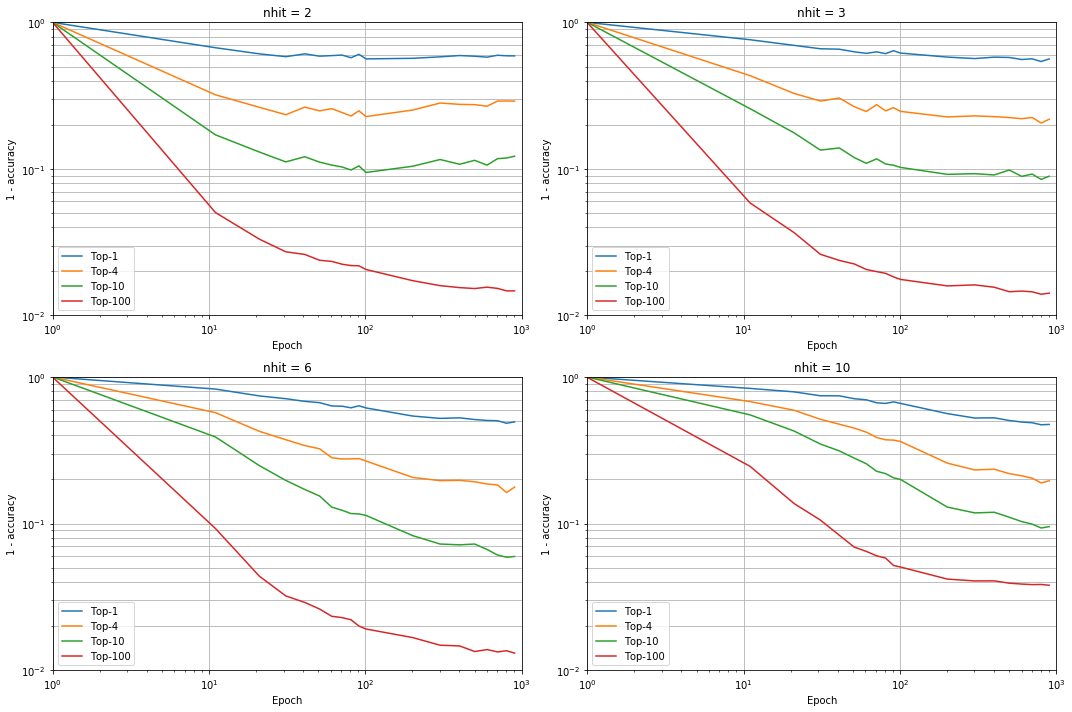

In [39]:
modelname = "A0010b"

plt.figure(figsize=(15,10))

for i, nhits in enumerate(nhits_testplot):
    
    plt.subplot(2,2,i+1)

    plt.grid(b=True,which='both',axis='y')
    plt.grid(b=True,which='major',axis='x')
    
    for kchoice in klist_testplot:
        plt.plot(epochs+1, 1-np.array(testacclists[modelname][(nhits,kchoice)]),
                 label = 'Top-' + str(kchoice))
    plt.legend()
    plt.ylim([1e-2,1])
    plt.xlim([1,1000])
    plt.semilogy()
    plt.semilogx()

    plt.xlabel('Epoch')
    plt.ylabel('1 - accuracy')
    plt.title('nhit = ' + str(nhits))

plt.tight_layout()
plt.show()

The top-100 and top-10 accuracy for the 10th hit is a little worse than I would like (97% and 90% accurate). Still, the performance hasn't plateaud at 1000 epochs so it can be improved with more training. In another notebook I will investigate the failing hits to see what is going wrong in those cases. We see that especially the top-1, top-4, top-10 accuracies for the 10th hit are still quickly improving after 1000 epochs, while the lower nhits have plateaud or in some cases declining. I think we are more interested in the higher nhit cases for this NN, since the first ~3 hits can be selected with a dedicated seeding algorithm.

### Utility of this NN

The utility that I envisage for this NN (or one like it) is as follows. At an intermediate stage in track assignment, you have one or more partially completed tracks and a very large number of unassigned hits. We want to either:

1) Find the next hit to assign to a given track, or
2) Find a track to which a given hit is to be assigned.

In either case, this NN can be used to select a plausible and manageably small set of hits that could be added to a track. E.g. in case 1), you would take your track and then select say all modules which the NN assignes a greater than 1% probability for the next hit in this track, and collect the set of hits in those modules. Then you can have a dedicated NN or other system for going through all those hits and choosing the best one to feed to the growing track.